In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('ticks', {"axes.linewidth": "1",'axes.yaxis.grid':False})

In [2]:
import numpy as np
import pickle as pk
import pandas as pd
from scipy import stats
import behavior.BehavioralCharacterizer as BC

from rnn_analysis import utils
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import scipy.stats as stats

import sys
PATH_ = '/om/user/rishir/lib/MentalPong/behavior/'
sys.path.insert(0, PATH_)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [3]:
figoutpath = '/om/user/rishir/figs/mpong/hum_monk/'

In [4]:
def load_one_behavior_mental_tracking(fn):
    def clean_df(df):
        return df.loc[:,~df.columns.duplicated()]
    dat = pk.load(open(fn, 'rb'))
    df_full = dat.datasets[0]['scalar']
    df_full['session_date_int'] = np.nan
    row_idx = df_full['session_date'].index
    df_full.loc[row_idx,'session_date_int'] = df_full['session_date'].astype(int)
    
    df_occ = df_full.query('ignore == 0 & occ_alpha == 1').reset_index(drop=True)
    df_vis = df_full.query('ignore == 0 & occ_alpha < 1').reset_index(drop=True)
    print('%s : \n %d occ trials, %d vis trials' % (fn, df_occ.shape[0], df_vis.shape[0]))
    
    df_vis = clean_df(df_vis)
    df_occ = clean_df(df_occ)
    return df_vis, df_occ

fn = '/om/user/rishir/data/pong_basic/RF/occluded_pong_bounce1_pad8_4speed/valid_meta_sample.pkl'
meta_sample = pd.read_pickle(fn)
fn = '/om/user/rishir/data/pong_basic/RF/occluded_pong_bounce1_pad8_4speed/valid_meta_sample_full.pkl'
meta_augmented = pd.read_pickle(fn)
meta_augmented.index = meta_augmented['meta_index']

def get_meta_augmented(df):
    df = df.reset_index(drop=True)
    idx = np.array(df['py_meta_index'].astype('int'))
    meta_reg = meta_augmented.loc[idx]
    meta_reg['py_meta_index_reg'] = meta_reg.index
    meta_reg = meta_reg.reset_index(drop=True)
    df = pd.concat([df, meta_reg], axis=1)
    df = df.loc[:,~df.columns.duplicated()]
    df['abs_dy_rnn'] = np.abs(df['dy_rnn'])
    df['time_occluded'] = df['t_f'] - df['t_occ']
    return df


In [5]:
tmp = {
    'Human': '/om/user/rishir/data/behavior/human_pong_basic.pkl',
    'Human2': '/om/user/rishir/data/behavior/human_pong_basic_heldout.pkl',
    'Carmen': '/om/user/rishir/data/behavior/carmen_pong_basic.pkl',
    'Perle': '/om/user/rishir/data/behavior/perle_pong_basic.pkl',
    'Monkey': '/om/user/rishir/data/behavior/monkey_CP_pong_basic.pkl',
}
data_full = {}
data_df_v, data_df = {},{}
for fk in tmp.keys():
    tmp_ = pk.load(open(tmp[fk], 'rb'))
    data_full[fk] = tmp_
    
    v,o = load_one_behavior_mental_tracking(tmp[fk])
    data_df_v[fk] = v
    data_df[fk] = o
    
for fk in data_df.keys():
    df = data_df[fk]
    data_df[fk] = get_meta_augmented(df)


/om/user/rishir/data/behavior/human_pong_basic.pkl : 
 6701 occ trials, 2284 vis trials
/om/user/rishir/data/behavior/human_pong_basic_heldout.pkl : 
 2458 occ trials, 247 vis trials
/om/user/rishir/data/behavior/carmen_pong_basic.pkl : 
 19684 occ trials, 6649 vis trials
/om/user/rishir/data/behavior/perle_pong_basic.pkl : 
 19788 occ trials, 6716 vis trials
/om/user/rishir/data/behavior/monkey_CP_pong_basic.pkl : 
 39472 occ trials, 13365 vis trials


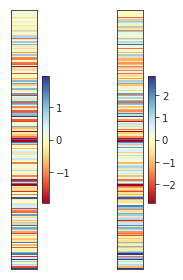

In [6]:
colormap = plt.cm.RdYlBu #my_cmap#
f,axes = plt.subplots(1,2,figsize=(4,4))
sd_factor = 2.0
data_df_oi = [data_df['Human'], data_df['Monkey']]
for dfi,df in enumerate(data_df_oi):
    x = np.array(df.groupby('py_meta_index')['paddle_error_signed'].mean())
    m,M = -np.nanstd(x)*sd_factor, np.nanstd(x)*sd_factor
    im = axes[dfi].imshow(np.reshape(x,(200,1)), cmap=colormap, 
                 interpolation='none',  clim=(m,M), aspect=0.05)
    h = f.colorbar(im,ax=axes[dfi], fraction=0.046, pad=0.04)
    axes[dfi].set_xticks([])
    axes[dfi].set_yticks([])
    plt.tight_layout()
f.savefig('%s/heatmap_behavior.pdf' % (figoutpath))

In [7]:
def plot_least_squares_line(x,y, ax):
    ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), 
            'r-', linewidth=2)
    return

def plot_error_vs_metaparam_base(df_mu, xvar, yvar, axes=None):
    if axes is None:
        f,axes = plt.subplots(1,1, figsize=(4,4))
    x,y = df_mu[xvar], df_mu[yvar]
    axes.plot(x,y, 'ko', mec='w')
    axes.set_xlabel(xvar)
    r,p = pearsonr(x,y)
    axes.set_title('r=%2.2f, p=%2.2e' % (r,p))
    plot_least_squares_line(x,y, axes)
    sns.despine(ax=axes, offset=5)
    return axes

def plot_error_vs_metaparam_v1(df_fk, error_metricn='paddle_error_signed', abs_y=False):
    df = data_df[df_fk]
    df2 = get_meta_augmented(df)
    task_vars = [
        ['ball_offset_x', 'ball_offset_y','yf_mworks'],
        ['dx_rnn', 'dy_rnn', 'abs_dy_rnn'],
        ['y_occ_rnn', 'n_bounce_correct', 'time_occluded'],
    ]
    f,axes = plt.subplots(3,3, figsize=(8,8))
    df_mu = df2.groupby('py_meta_index').mean()
    df_mu['abs_%s'%error_metricn] = np.abs(df_mu[error_metricn])
    for i in range(3):
        for j in range(3):
            tv = task_vars[i][j]
            yv = error_metricn
            if abs_y:
                yv = 'abs_%s' % error_metricn
            ax = axes[i,j]
            plot_error_vs_metaparam_base(df_mu, tv, yv, axes=ax)
    plt.tight_layout()
    f.savefig('%s/error_v_task_params_%s.pdf' % (figoutpath, df_fk))
    return

def regress_error_vs_metaparam(model_fn='Human'):
    tmp = get_mental_vs_visual_errors(data_df[model_fn])
    feature_fns = ['ball_offset_x', 'ball_offset_y','dx_rnn', 'dy_rnn']
    label_fn = 'paddle_error_signed'
    reg = LinearRegression()
    data1, data2 = train_test_split(tmp, test_size=0.5, random_state=0)
    reg.fit(data1[feature_fns], data1[label_fn])
    y_pred = reg.predict(data2[feature_fns])
    y_true = data2[label_fn]
    
    x,y = y_true, y_pred
    f,axes = plt.subplots(1,1, figsize=(4,4))
    axes.plot(x,y, 'ko', mec='w')
    axes.plot(x,x, 'r:')
    r,p = pearsonr(x,y)
    axes.set_title('r=%2.2f, p=%2.2e' % (r,p))
    sns.despine(ax=axes, offset=5)
    f.savefig('%s/regress_error_%s_v2.pdf' % (figoutpath, model_fn))
    return 

def get_mental_vs_visual_errors(df):
    tmp = df.groupby('py_meta_index').mean()
    tmp['py_meta_index'] = tmp.index
    for bsi, ball_size in enumerate(['hum', 'rnn']): # 0.5 for rnn, 0.4 for hum
        d_f = tmp['paddle_y'] - tmp['y_f_%s_mwk' % ball_size]
        d_o = tmp['paddle_y'] - tmp['y_occ_%s_mwk' % ball_size]
        d_i = tmp['paddle_y'] - tmp['y_i_%s_mwk' % ball_size]
        for xi, xvar in enumerate([d_f, d_i]):
            d0 = np.abs(d_o) - np.abs(xvar)
            tmp['mental_vs_visual_x_%s_dfi%d' % (ball_size, xi)] = np.abs(d_o) 
            tmp['mental_vs_visual_y_%s_dfi%d' % (ball_size, xi)] = np.abs(xvar) 
            tmp['mental_vs_visual_error_%s_dfi%d' % (ball_size, xi)] = d0
    tmp = tmp.reset_index(drop=True)
    return tmp

def plot_error_visual_vs_mental(model_fn='Human'):
    tmp = get_mental_vs_visual_errors(data_df[model_fn])
    f,axes = plt.subplots(2,2,figsize=(5,5))
    for bsi, ball_size in enumerate(['hum', 'rnn']): # 0.5 for rnn, 0.4 for hum
        for xi in range(2): # final position, interception position
            yfn = 'mental_vs_visual_error_%s_dfi%d' % (ball_size, xi)
            ax = axes[bsi,xi]
            plot_error_vs_metaparam_base(tmp, 'yf_mworks', yfn, axes=ax)
    plt.tight_layout()
    f.savefig('%s/%s_mental_visual_residual_vs_yf.pdf' % (figoutpath, model_fn))
    return

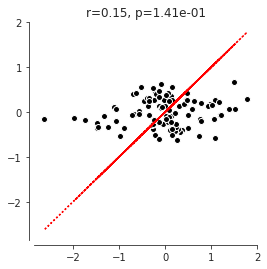

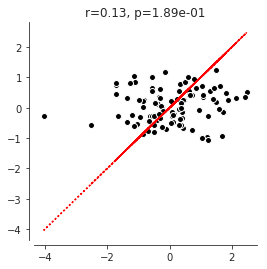

In [8]:
regress_error_vs_metaparam(model_fn='Human')
regress_error_vs_metaparam(model_fn='Monkey')

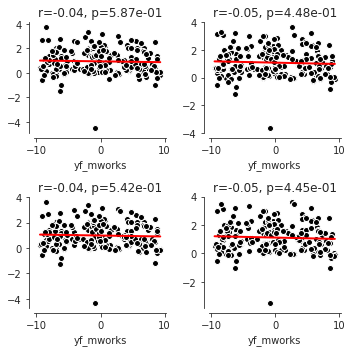

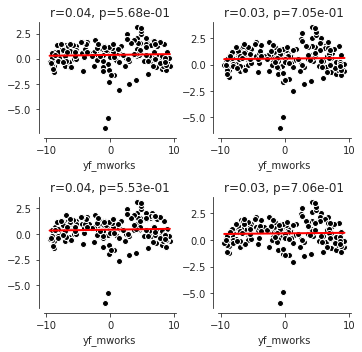

In [9]:
plot_error_visual_vs_mental(model_fn='Human')
plot_error_visual_vs_mental(model_fn='Monkey')

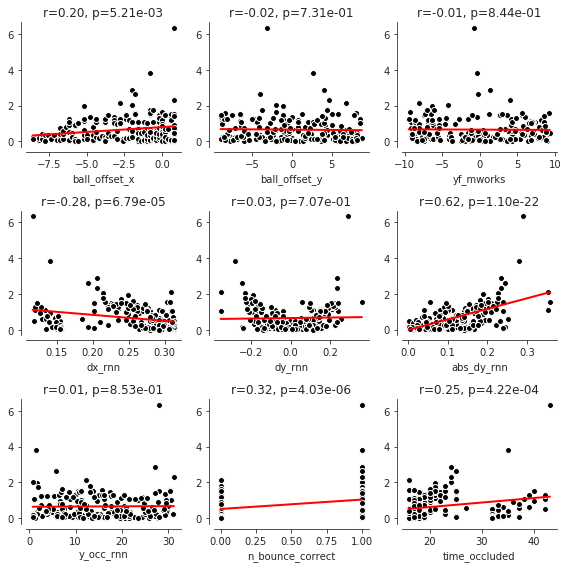

In [10]:
plot_error_vs_metaparam_v1('Human', error_metricn='paddle_error_signed', abs_y=True)

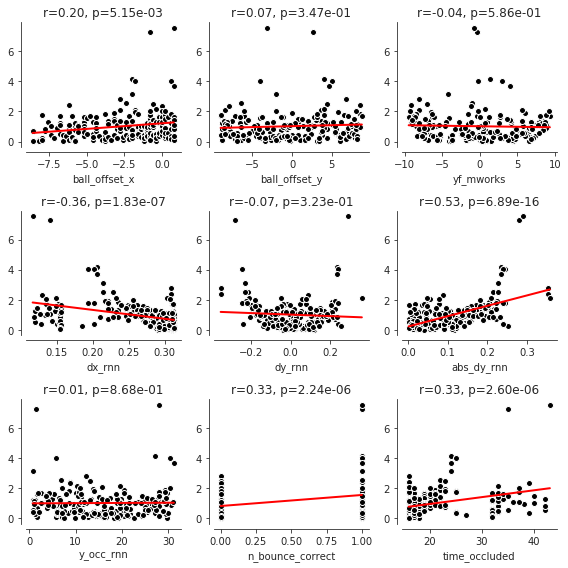

In [11]:
plot_error_vs_metaparam_v1('Monkey', error_metricn='paddle_error_signed', abs_y=True)

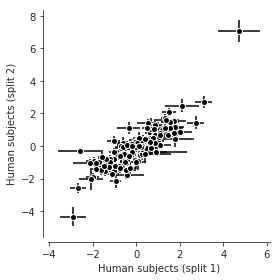

In [12]:
df = data_df['Human']
subs = df['session'].unique()
nsubs = subs.shape[0]
# different split every time this is run, so not replicable across runs.
t1 = np.random.choice(range(nsubs), 6, replace=False)
t2 = np.setdiff1d(range(nsubs), t1)
subs_split1, subs_split2 = subs[t1], subs[t2]
df1 = df[df['session'].isin(subs_split1)]
df2 = df[df['session'].isin(subs_split2)]

D1 = df1.groupby('py_meta_index')['paddle_error_signed']
D2 = df2.groupby('py_meta_index')['paddle_error_signed']
m1,s1 = D1.mean(), D1.sem()
m2,s2 = D2.mean(), D2.sem()
f,axes = plt.subplots(1,1,figsize=(4,4))
axes.errorbar(m1, m2, xerr=s1, yerr=s2, fmt='ko', mec='w')

sns.despine(ax=axes, offset=5)
axes.set_xlabel('Human subjects (split 1)')
axes.set_ylabel('Human subjects (split 2)')
plt.tight_layout()
f.savefig('%s/hum_compare_across_splitsubjects.pdf' % figoutpath)



In [13]:
def get_bias_variance(df):
    x = df['paddle_y']
    y = df['yf_mworks']
    df['sq_err'] = (x-y)**2
    rmse = df.groupby('py_meta_index').mean()['sq_err']
    stderr = df.groupby('py_meta_index').std()['paddle_y']
    tmp = df.groupby('py_meta_index').mean()
    x = tmp['paddle_y']
    y = tmp['yf_mworks']
    root_bias = ((x-y)**2)**0.5

    res = {
        'rmse':rmse, 
        'stderr':stderr, 
        'root_bias':root_bias,
        'paddle_y': x,
        'yf_mworks': y
    }
    return res

def plot_bias_variance(df_v, df_o, label, axes, col='k'):
    res_v = get_bias_variance(df_v)
    res_o = get_bias_variance(df_o)
    X = [res_v['root_bias'].mean(), res_o['root_bias'].mean()]
    Y = [res_v['stderr'].mean(), res_o['stderr'].mean()]
    axes.plot(X,Y, '-o', label=label, color=col, markersize=4)
    axes.plot(res_o['root_bias'].mean(), 
              res_o['stderr'].mean(), 'D', label=label, color=col)
    axes.set_xlim([0,2.5])
    axes.set_ylim([0,2.5])
    sns.despine(ax=axes, offset=5)
    return

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

def plot_grid(axes):
    XY = []
    for r in [1,2,3]:
        for th in np.linspace(-np.pi, np.pi, 100):
            XY.append(pol2cart(r, th))
    XY = np.array(XY)
    axes.plot(XY[:,0], XY[:,1], 'k:')
    return

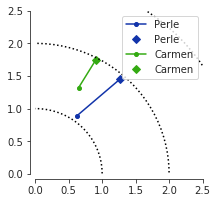

In [14]:
cols =  ['#1234aa', '#34aa12']
f,axes = plt.subplots(1,1,figsize=(3,3))
for fki,fk in enumerate(['Perle', 'Carmen']):
    df_v, df_o = data_df_v[fk], data_df[fk]
    label = fk
    col = cols[fki]
    plot_bias_variance(df_v, df_o, label, axes, col=col)
axes.legend()
plot_grid(axes)
f.savefig('%s/monkey_bias_v_var.pdf' % figoutpath)

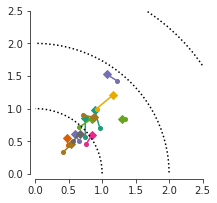

In [18]:
fk = 'Human'
df_v, df_o = data_df_v[fk], data_df[fk]

colormap = plt.cm.Dark2
f,axes = plt.subplots(1,1,figsize=(3,3))
nsubs = df_v['session'].unique().shape[0]
for usi, us in enumerate(df_v['session'].unique()):
    col = colormap((usi*1.0)/nsubs)
    df_v_ = df_v.query('session == "%s"' % us).reset_index(drop=True)
    df_o_ = df_o.query('session == "%s"' % us).reset_index(drop=True)
    plot_bias_variance(df_v_, df_o_, '', axes, col=col)
plot_grid(axes)
f.savefig('%s/hum_bias_v_var.pdf' % figoutpath)


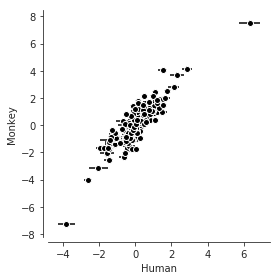

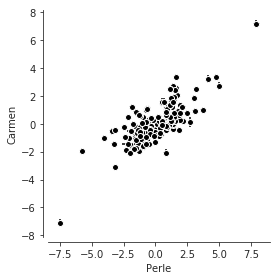

In [20]:

def scatter_compare(fk1, fk2):
    D1 = data_df[fk1].groupby('py_meta_index')['paddle_error_signed']
    D2 = data_df[fk2].groupby('py_meta_index')['paddle_error_signed']
    m1,s1 = D1.mean(), D1.sem()
    m2,s2 = D2.mean(), D2.sem()
    f,axes = plt.subplots(1,1,figsize=(4,4))
    axes.errorbar(m1, m2, xerr=s1, yerr=s2, fmt='ko', mec='w')
    sns.despine(ax=axes, offset=5)
    axes.set_xlabel(fk1)
    axes.set_ylabel(fk2)
    plt.tight_layout()
    f.savefig('%s/compare_%s_%s_error_signed_raw.pdf' % (figoutpath, fk1, fk2))
    return

scatter_compare('Human', 'Monkey')
scatter_compare('Perle', 'Carmen')

In [21]:
full_fn = '/om/user/rishir/lib/MentalPong/dat/comparison_full_pred.pkl'
compare_full = pk.load(open(full_fn, 'rb'))

In [22]:
def get_abs_displacement(x):
    return np.abs(np.diff(x, axis=1))

def flat_array(x):
    return x[np.isfinite(x)].flatten()

def get_movement_onset(x_mat):
    scale = 41.666
    rt1, rt2 = [], []
    for x in x_mat:
        start_t = np.nonzero((x>0) & (np.isfinite(x)))[0][0]
        end_t_ = np.nonzero(np.isnan(x))[0]
        end_t = end_t_[end_t_>start_t][0]

        rt1.append(start_t*scale) # rel to start
        rt2.append((start_t-end_t)*scale)
    return np.array(rt1), np.array(rt2)
       
def get_mean_paddle_timeseries(model_dat_fn='Humanocc', mask_fn='output_vis'):
    X = compare_full.res_model_dat[model_dat_fn]['pos']['mu'][0]
    mask = compare_full.masks[mask_fn]
    Y = np.array(X)
    Y[np.isnan(mask)] = np.nan
    return Y

def get_all_movement_metrics(model_dat_fn):
#     model_fn = 'Humanocc'
    x_vis = get_mean_paddle_timeseries(model_dat_fn=model_dat_fn, 
                                       mask_fn='output_vis')
    x_occ = get_mean_paddle_timeseries(model_dat_fn=model_dat_fn,
                                       mask_fn='output_sim')
    diff_vis = get_abs_displacement(x_vis)
    diff_occ = get_abs_displacement(x_occ)
    rt_mov1, rt_mov2 = get_movement_onset(diff_vis)
    res = {
        'diff_vis':diff_vis,
        'diff_occ':diff_occ,
        'rt_mov1':rt_mov1,
        'rt_mov2':rt_mov2,
    }
    return res

def plot_movement_metrics(model_fn):

    res = get_all_movement_metrics(model_fn)
    f,axes = plt.subplots(2,2,figsize=(3,5))
    for vi,vfk in enumerate(['rt_mov1', 'rt_mov2']):
        v = res[vfk]
        axes[0,vi].violinplot(v, showmedians=True)
        axes[0,vi].set_title(vfk)
        axes[0,vi].set_xticks([])
        if vi == 0:
            axes[0,vi].set_ylim([0,1000])
        else:
            axes[0,vi].set_ylim([-2000,0])
        sns.despine(ax=axes[0,vi], offset=5)

    for vi,vfk in enumerate(['diff_vis', 'diff_occ']):
        v = res[vfk]
        axes[1,vi].violinplot(flat_array(v), showmedians=True)
        axes[1,vi].set_ylim([-0.1, 0.75])
        axes[1,vi].set_title(vfk)
        axes[1,vi].set_xticks([])
        sns.despine(ax=axes[1,vi], offset=5)

    plt.tight_layout()
    f.savefig('%s/movement_rt_disp_%s.pdf' % (figoutpath, model_fn))
    return res

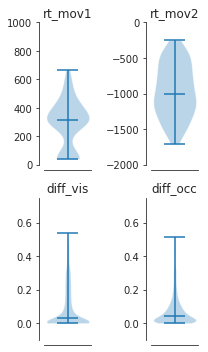

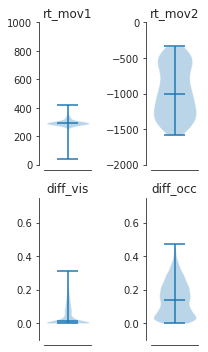

In [23]:
res_h = plot_movement_metrics('Humanocc')
res_m = plot_movement_metrics('Monkeyocc')